In [ ]:
from calculate_parameter_range import *
import seaborn as sns

# Load data

In [6]:
print_on = False

In [7]:
df = load_data()

if print_on:
    for col in df.columns:
        print(col)

In [8]:
# Subset to only include field growing conditions?
#df = df[(df.Growthcond=='field') | (df.Growthcond=='Field')]

# Process data

In [9]:
df = process_data(df)
df = classify_observations(df)

##### Check classifications

In [6]:
# Check that broad PFT categories make sense
if print_on: 
    print('PFT Categories')
    print(np.unique(df['PFT_category']))
    for category_test in PFT_CATEGORIES:
        print('----------------------')
        print(category_test)
        print('Pathways:   '+str(np.unique(df[df['PFT_category']==category_test]['Pathway'])))
        print('Plantforms: '+str(np.unique(df[df['PFT_category']==category_test]['Plantform'])))
        print('Types:      '+str(np.unique(df[df['PFT_category']==category_test]['Type'])))
        print('Leafspans:  '+str(np.unique(df[df['PFT_category']==category_test]['Leafspan'])))
        print('Tregions:   '+str(np.unique(df[df['PFT_category']==category_test]['Tregion'])))

In [7]:
# Check that broad PFT categories make sense
if print_on:
    print('PFT Numbers: ')
    print(np.unique(df['PFT_num']))
    for i, category_test in enumerate(np.unique(df['PFT_num'])):
        print('----------------------')
        print(category_test)
        print(PFTS[i])
        print('Pathways:   '+str(np.unique(df[df['PFT_num']==category_test]['Pathway'])))
        print('Plantforms: '+str(np.unique(df[df['PFT_num']==category_test]['Plantform'])))
        print('Types:      '+str(np.unique(df[df['PFT_num']==category_test]['Type'])))
        print('Leafspans:  '+str(np.unique(df[df['PFT_num']==category_test]['Leafspan'])))
        print('Tregions:   '+str(np.unique(df[df['PFT_num']==category_test]['Tregion'])))

# Check distributions of variables

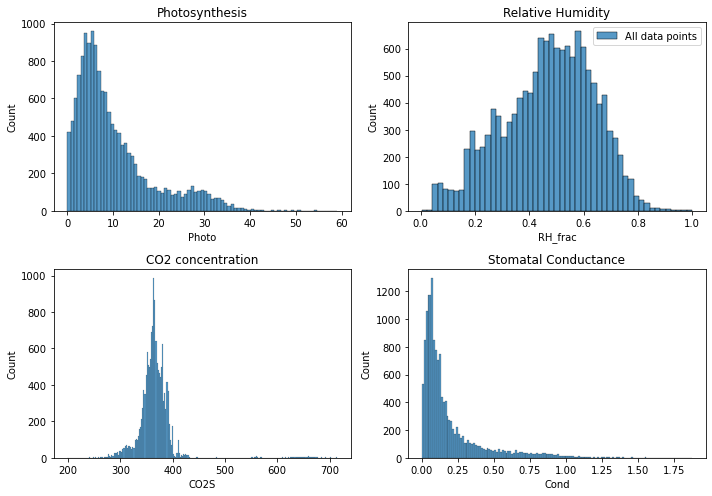

In [8]:
data_filter=df['RH_frac']>0.1
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.title('Photosynthesis')
sns.histplot(df['Photo'])
plt.subplot(2,2,2)
plt.title('Relative Humidity')
sns.histplot(df['RH_frac'], label='All data points')
plt.legend(fontsize=10)
plt.subplot(2,2,3)
plt.title('CO2 concentration')
sns.histplot(df['CO2S'])
plt.subplot(2,2,4)
plt.title('Stomatal Conductance')
sns.histplot(df['Cond'])
plt.tight_layout()

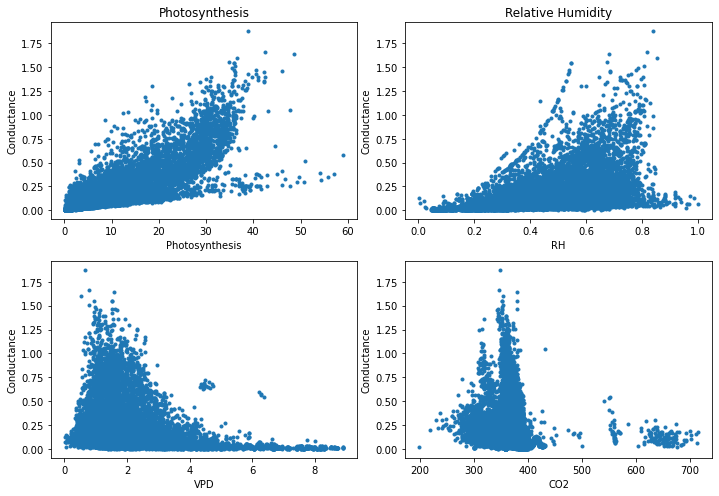

In [9]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.title('Photosynthesis')
plt.plot(df['Photo'],df['Cond'],'.')
plt.ylabel('Conductance')
plt.xlabel('Photosynthesis')

plt.subplot(2,2,2)
plt.title('Relative Humidity')
plt.plot(df['RH_frac'],df['Cond'],'.')
plt.xlabel('RH')
plt.ylabel('Conductance')

plt.subplot(2,2,3)
plt.plot(df['VPD'],df['Cond'],'.')
plt.xlabel('VPD')
plt.ylabel('Conductance')

plt.subplot(2,2,4)
plt.plot(df['CO2S'],df['Cond'],'.')
plt.xlabel('CO2')
plt.ylabel('Conductance')

plt.tight_layout()

# Calculate stomatal slope for PFTs

In [10]:
[PFT_avgs, df_BB, predictions] = calc_BB_slope(df, random_effect=False)

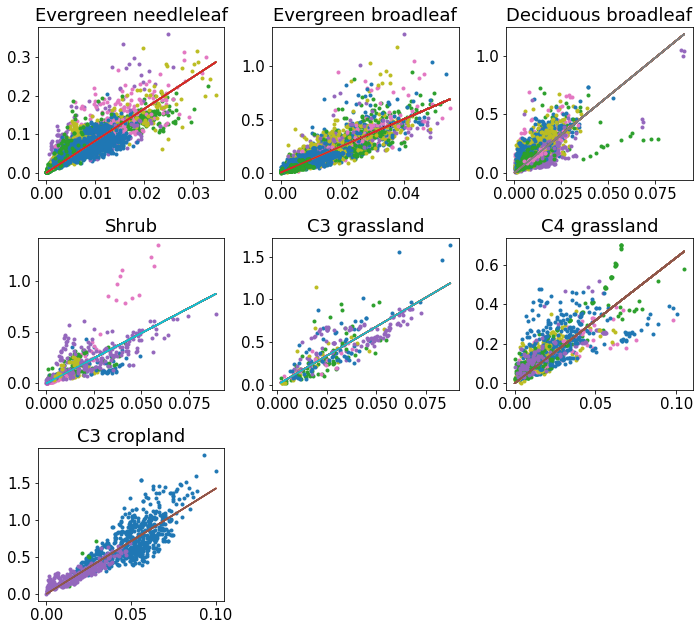

In [11]:
plt.figure(figsize=[10,9])
plt.rcParams.update({'font.size': 15})

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments

for i, PFT_category in enumerate(PFT_CATEGORIES):
    plt.subplot(3,3,i+1)
    #Subset to single PFT
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]

    # Make figure
    for species in df_subset['Species'].unique():
        plt.plot(df_subset[df_subset['Species']==species].xvals_BB, 
                 df_subset[df_subset['Species']==species].yvals_BB,'.')
        plt.plot(df_subset["xvals_BB"], predictions[i])
    plt.title(PFT_category)
    
    # Print Summary
    if print_on:
        print('--------------')
        print(PFT_category)
        print('g1 estimate: '+str(np.size(df_subset['Species'].unique()))+' species')
        print(np.round(PFT_avgs[i],3))
plt.tight_layout()

In [12]:
print(PFT_CATEGORIES)
print(PFT_avgs)

['Evergreen needleleaf', 'Evergreen broadleaf', 'Deciduous broadleaf', 'Shrub', 'C3 grassland', 'C4 grassland', 'C3 cropland']
[ 8.30575883 12.59438238 13.09811861  9.76883049 13.61834695  6.36468816
 14.23800603]


# Calculate range of stomatal slope for PFTs

In [13]:
[df_g1, df_BB] =calc_BB_slope_range(df)

/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [14]:
df_g1

,PFT_category,g1_5pct,g1_mean,g1_95pct,num_datapoints,num_species,count_missing_replicates,num_replicates_not_counted,num_replicates_counted,species_g1s
0,Evergreen needleleaf,5.965157,9.472053,14.934662,4395,12,0,0,4395,"[14.466556399449342, 11.966492754887305, 6.039..."
1,Evergreen broadleaf,6.973301,10.604263,18.036784,3450,202,0,0,3450,"[16.75080519087133, 10.146380539463408, 11.569..."
2,Deciduous broadleaf,7.997697,13.672372,19.414341,2729,19,0,0,2729,"[4.400440121072202, 11.15811311367312, 12.7473..."
3,Shrub,5.443039,11.290417,16.985342,686,15,0,0,686,"[11.966901544791318, 13.844823505974011, 7.225..."
4,C3 grassland,8.658585,12.845295,18.795034,304,20,0,0,304,"[19.49594654765118, 17.736764971112112, 12.906..."
5,C4 grassland,3.959360,7.120723,11.184132,1153,38,0,0,1153,"[8.190325195370722, 8.738866441385529, 3.97025..."
6,C3 cropland,13.302011,15.833999,19.436352,844,3,0,0,844,"[14.304907410523832, 20.00651267533402, 13.190..."


# Make figures showing histograms of g1 values

/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

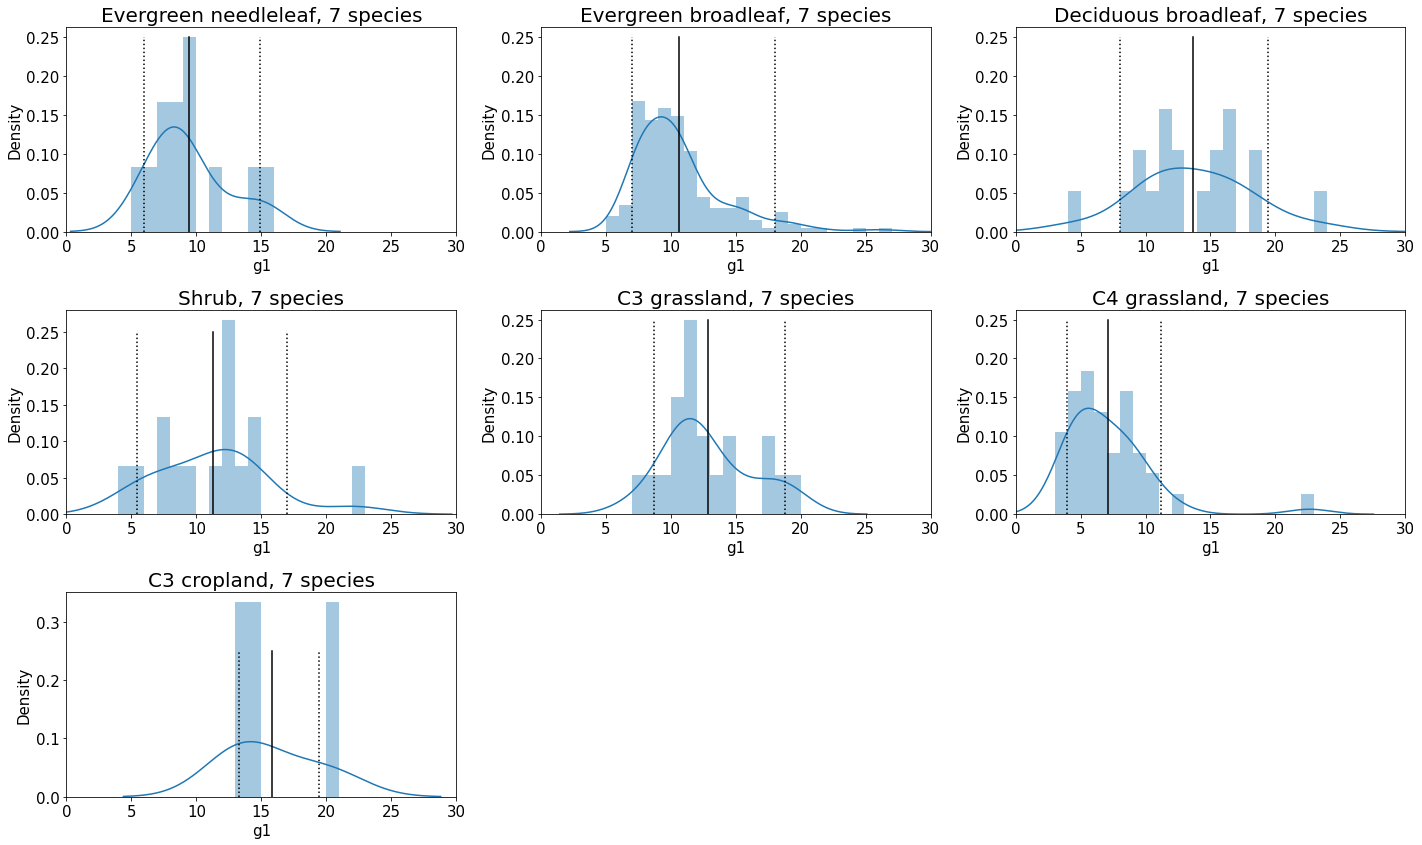

In [15]:
plt.figure(figsize=[20,12])
plt.rcParams.update({'font.size': 15})

for j, PFT_category in enumerate(PFT_CATEGORIES):
    
    plt.subplot(3,3,j+1)
    
    # Make subplot
    output = sns.distplot(np.array(df_g1.species_g1s[j]), bins=np.arange(0,50,1))
    plt.xlim([0, 30])
    plt.xlabel('g1')
    plt.plot([df_g1.g1_5pct[j], df_g1.g1_5pct[j]],[0,0.25],':k')
    plt.plot([df_g1.g1_mean[j], df_g1.g1_mean[j]],[0,0.25],'-k')
    plt.plot([df_g1.g1_95pct[j], df_g1.g1_95pct[j]],[0,0.25],':k')
    plt.title(PFT_category+', '+str(len(df_g1.species_g1s))+' species', fontsize=20)
        
plt.tight_layout()
plt.savefig('Histograms.png')

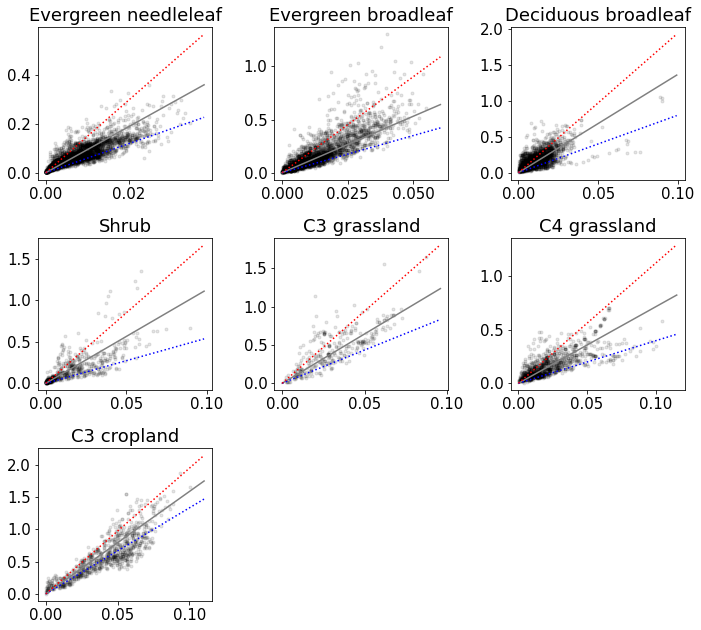

In [17]:
plt.figure(figsize=[10,9])
plt.rcParams.update({'font.size': 15})

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments

for i, PFT_category in enumerate(PFT_CATEGORIES):
    plt.subplot(3,3,i+1)
    #Subset to single PFT
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    

    # Make figure
    plt.plot(df_subset.xvals_BB, df_subset.yvals_BB,'.k',alpha=0.1)
    xrange = np.linspace(0,np.nanmax(df_subset.xvals_BB)*1.1,20)
    m_mean=df_g1[df_g1.PFT_category==PFT_category].g1_mean.values[0]
    m_low=df_g1[df_g1.PFT_category==PFT_category].g1_5pct.values[0]
    m_high=df_g1[df_g1.PFT_category==PFT_category].g1_95pct.values[0]
    plt.plot(xrange, m_mean*xrange,'-',color='gray')
    plt.plot(xrange, m_low*xrange,':b')
    plt.plot(xrange, m_high*xrange,':r')
    plt.title(PFT_category)
    
    # Print Summary
    if print_on:
        print('--------------')
        print(PFT_category)
        print('g1 estimate: '+str(np.size(df_subset['Species'].unique()))+' species')
        print(np.round(PFT_avgs[i],3))
plt.tight_layout()

# Alternative of calculation (1 per X)

In [18]:
df_BB['mbbopt'] = df_BB['yvals_BB']/df_BB['xvals_BB']

Evergreen needleleaf
12.328744584011734
9.894546377748105
Evergreen broadleaf
14.960062949633727
11.603451423003184
Deciduous broadleaf
20.913782568161626
14.70621444595793
Shrub
17.23233037947589
12.124352364804505
C3 grassland
14.886598594741228
12.805340157598135
C4 grassland
9.665723304173984
7.492153722579041
C3 cropland
17.7587420363264
14.0973110622353


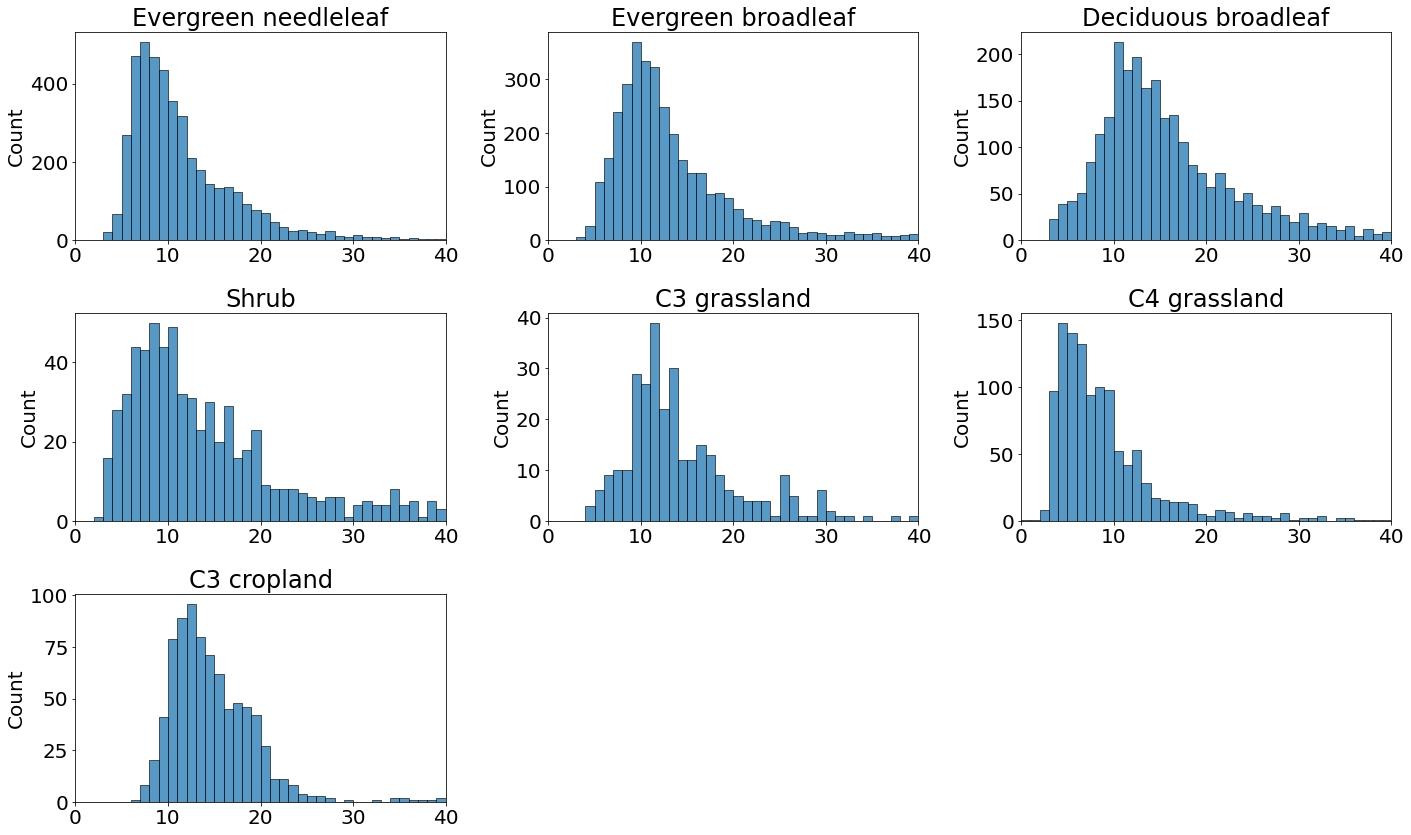

In [19]:
plt.rcParams.update({'font.size': 20})

ibins = np.arange(0,50,1)
# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments
plt.figure(figsize=[20,12])
for j, PFT_category in enumerate(PFT_CATEGORIES):
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    plttitle=PFT_category
    plt.subplot(3,3,j+1)

    output = sns.histplot(df_subset['mbbopt'].values, bins=ibins)
    plt.xlim([0, 40])
    plt.title(plttitle)
    
    print(PFT_category)
    print(np.nanmean(df_subset['mbbopt'].values))
    print(np.nanmedian(df_subset['mbbopt'].values))
plt.tight_layout()
plt.savefig('Histograms.png')

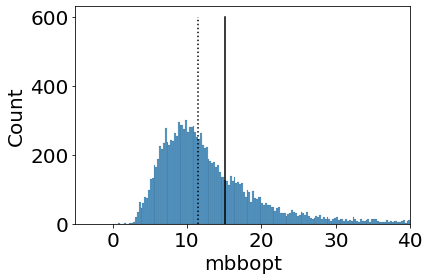

In [20]:
sns.histplot(df_BB['mbbopt'], bins=np.arange(0,100,0.25))
plt.xlim([-5,40])
plt.plot([np.nanmean(df_BB['mbbopt']),np.nanmean(df_BB['mbbopt'])],
         [0,600],'-k')
plt.plot([np.nanmedian(df_BB['mbbopt']),np.nanmedian(df_BB['mbbopt'])],
         [0,600],':k')

# Make dataset mapping low and high values to PFTs

In [21]:
df = pd.read_csv('e3sm_pfts.csv')

In [22]:
#df.pft_categories.unique()
df_categories = ['Needleleaf', 'Evergreen broadleaf', 'Deciduous broadleaf',
       'Shrub', 'C3 grassland', 'C4 grassland / cropland', 'C3 cropland']
g1_categories=['Evergreen needleleaf', 'Evergreen broadleaf',
       'Deciduous broadleaf', 'Shrub', 'C3 grassland', 'C4 grassland',
       'C3 cropland']

In [23]:
for i, df_category in enumerate(df_categories):
    g1_category = g1_categories[i]
    df.loc[df.pft_categories==df_category,'mbbopt_mean'] = np.round(df_g1[df_g1.PFT_category==g1_category]['g1_mean'].values[0],2)
    df.loc[df.pft_categories==df_category,'mbbopt_5thpct'] = np.round(df_g1[df_g1.PFT_category==g1_category]['g1_5pct'].values[0],2)
    df.loc[df.pft_categories==df_category,'mbbopt_95thpct'] = np.round(df_g1[df_g1.PFT_category==g1_category]['g1_95pct'].values[0],2)
    
df.loc[0,'mbbopt_mean']=9
df.loc[0,'mbbopt_5thpct']=9
df.loc[0,'mbbopt_95thpct']=9

In [24]:
df=df.dropna(how='all')

In [25]:
df

,﻿pftnum,pftname,pft_categories,mbbopt_original,mbbopt_mean,mbbopt_5thpct,mbbopt_95thpct
0,0,not_vegetated,NaN,9,9.00,9.00,9.00
1,1,needleleaf_evergreen_temperate_tree,Needleleaf,9,9.47,5.97,14.93
2,2,needleleaf_evergreen_boreal_tree,Needleleaf,9,9.47,5.97,14.93
3,3,needleleaf_deciduous_boreal_tree,Needleleaf,9,9.47,5.97,14.93
4,4,broadleaf_evergreen_tropical_tree,Evergreen broadleaf,9,10.60,6.97,18.04
5,5,broadleaf_evergreen_temperate_tree,Evergreen broadleaf,9,10.60,6.97,18.04
6,6,broadleaf_deciduous_tropical_tree,Deciduous broadleaf,9,13.67,8.00,19.41
7,7,broadleaf_deciduous_temperate_tree,Deciduous broadleaf,9,13.67,8.00,19.41
8,8,broadleaf_deciduous_boreal_tree,Deciduous broadleaf,9,13.67,8.00,19.41
9,9,broadleaf_evergreen_shrub,Shrub,9,11.29,5.44,16.99


Note: values from Frank et al. 2017 Table II


* Evergreen needleleaf: 7.88
* Evergreen broadleaf: 12.3
* Deciduous broadleaf: 13.1
* Shrub:               13.8
* C3 grassland:        15.1
* C4 grassland:         6.05
* C3 cropland:         16.5
* Arctic tundra:        7.55

# Make new parameter file netcdfs

In [26]:
dir_paramfiles = '/global/homes/c/czarakas/TREE2H2O/code/stomatal_slope_experiments/model_inputs/parameter_files/'
fname_default = dir_paramfiles+'clm_params_default.nc'

In [27]:
import xarray as xr
ds_default = xr.open_dataset(fname_default)

In [28]:
print(ds_default.bbbopt)

<xarray.DataArray 'bbbopt' (pft: 25)>
array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 40000., 10000., 10000., 40000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000.])
Coordinates:
    pftname  (pft) |S40 ...
Dimensions without coordinates: pft
Attributes:
    long_name:  
    units:      


In [29]:
ds_lowBB = ds_default.copy(deep=True)
ds_meanBB = ds_default.copy(deep=True)
ds_highBB = ds_default.copy(deep=True)

In [30]:
print_on=False

### Make new datasets

In [31]:
if print_on: print(ds_lowBB.mbbopt)
ds_lowBB.mbbopt.values = df.mbbopt_5thpct.values
if print_on: print('-----------------------------')
if print_on: print(ds_lowBB.mbbopt)

ds_lowBB.to_netcdf(path=dir_paramfiles+'clm_params_low.nc',
                   mode='w',
                   format="NETCDF3_64BIT")
test_low = xr.open_dataset(dir_paramfiles+'clm_params_low.nc')

In [32]:
if print_on: print(ds_meanBB.mbbopt)
ds_meanBB.mbbopt.values = df.mbbopt_mean.values
if print_on: print('-----------------------------')
if print_on: print(ds_meanBB.mbbopt)

ds_meanBB.to_netcdf(path=dir_paramfiles+'clm_params_mean.nc',
                   mode='w',
                   format="NETCDF3_64BIT")
test_mean = xr.open_dataset(dir_paramfiles+'clm_params_mean.nc')

In [33]:
if print_on: print(ds_highBB.mbbopt)
ds_highBB.mbbopt.values = df.mbbopt_95thpct.values
if print_on: print('-----------------------------')
if print_on: print(ds_highBB.mbbopt)

ds_highBB.to_netcdf(path=dir_paramfiles+'clm_params_high.nc',
                   mode='w',
                   format="NETCDF3_64BIT")
test_high = xr.open_dataset(dir_paramfiles+'clm_params_high.nc')

In [34]:
test_default = xr.open_dataset(dir_paramfiles+'clm_params_default.nc')

In [35]:
print(test_default.mbbopt.values)
print(test_low.mbbopt.values)
print(test_mean.mbbopt.values)
print(test_high.mbbopt.values)

[9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 4. 9. 9. 4. 9. 9. 9. 9. 9. 9.
 9.]
[ 9.    5.97  5.97  5.97  6.97  6.97  8.    8.    8.    5.44  5.44  5.44
  8.66  8.66  3.96 13.3  13.3   3.96  3.96 13.3  13.3  13.3  13.3  13.3
 13.3 ]
[ 9.    9.47  9.47  9.47 10.6  10.6  13.67 13.67 13.67 11.29 11.29 11.29
 12.85 12.85  7.12 15.83 15.83  7.12  7.12 15.83 15.83 15.83 15.83 15.83
 15.83]
[ 9.   14.93 14.93 14.93 18.04 18.04 19.41 19.41 19.41 16.99 16.99 16.99
 18.8  18.8  11.18 19.44 19.44 11.18 11.18 19.44 19.44 19.44 19.44 19.44
 19.44]
